In [2]:
# Test the imports first
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

# Create simple circuit
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

# Run 
backend = AerSimulator()
job = backend.run(qc, shots=100)
result = job.result()
print(result.get_counts())  

{'11': 51, '00': 49}


✓ All imports successful
QAOA QUANTUM NETWORK OPTIMIZATION - VALIDATION
3-Node Network, 1 Demand Pair

Network: 3 nodes, 3 edges
Demand: 0 -> 2

Edge Properties:
  (0,1): distance=2.0km, η=0.9120, F=0.9029
  (0,2): distance=4.0km, η=0.8318, F=0.8234
  (1,2): distance=3.0km, η=0.8710, F=0.8623
Edge to Qubit Mapping:
  Qubit 0: edge (0, 1) (or (1, 0))
  Qubit 1: edge (0, 2) (or (2, 0))
  Qubit 2: edge (1, 2) (or (2, 1))

Objective Weights (log fidelity):
  Qubit 0 edge (0,1): weight = -0.1022
  Qubit 1 edge (0,2): weight = -0.1943
  Qubit 2 edge (1,2): weight = -0.1482

Flow conservation penalty: A = 2.0
Applied to qubits 0 and 2

=== QUBO Matrix (3x3) ===
Variables: [r_01, r_02, r_12] (order may vary)

Q matrix:
[[ 2.10215374  0.         -4.        ]
 [ 0.          0.19425714  0.        ]
 [-4.          0.          2.14820544]]

Edge mapping: {(0, 1): 0, (1, 0): 0, (0, 2): 1, (2, 0): 1, (1, 2): 2, (2, 1): 2}

=== Brute Force Enumeration ===
Config | Cost
-------|------
[0 0 0]  | 0.0000

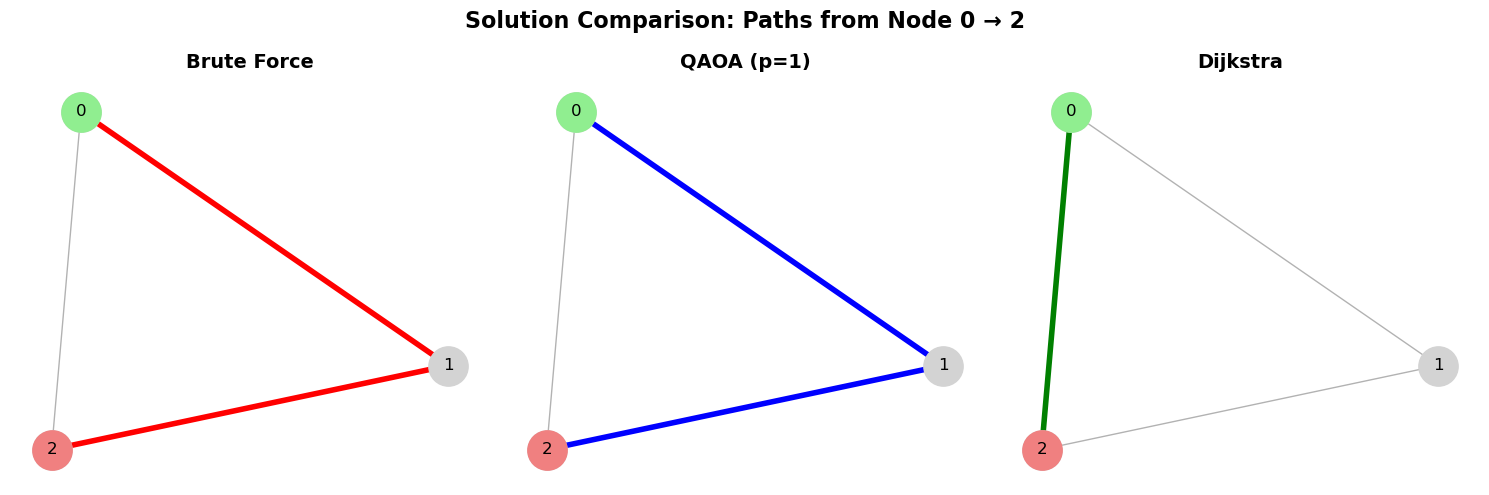

VALIDATION COMPLETE

Next Steps:
1. Hand-verify QUBO matrix calculation
2. Test with different penalty weights
3. Scale to 5-node network
4. Document findings


In [13]:
# QAOA Quantum Network Optimization - Validation 3-Node Network Test
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Fixed imports for Qiskit 1.0+
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

print("✓ All imports successful")

# STEP 1: Simple 3-Node Network
def create_simple_network():
    """Create 3-node triangle network for validation"""
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from([0, 1, 2])
    
    # Add edges with distances (km)
    edges_with_dist = [
        (0, 1, 2.0),  # Short edge
        (1, 2, 3.0),  # Medium edge  
        (0, 2, 4.0),  # Long edge (direct but lossy)
    ]
    
    # Quantum parameters
    alpha = 0.2  # Fiber attenuation (dB/km)
    F_0 = 0.99   # Initial Bell state fidelity
    
    for u, v, d in edges_with_dist:
        # Link efficiency: η = 10^(-α*L/10)
        eta = 10 ** (-alpha * d / 10)
        # Link fidelity (simplified model)
        fidelity = F_0 * eta
        
        G.add_edge(u, v, 
                   distance=d,
                   eta=eta,
                   fidelity=fidelity,
                   weight=-np.log(fidelity))  # For Dijkstra
    
    return G

def simple_demand():
    """Single demand: route from node 0 to node 2"""
    return {
        'source': 0,
        'destination': 2,
        'priority': 1.0
    }

# STEP 2: QUBO Construction
def construct_simple_qubo(network, demand):
    """
    Construct QUBO for 3-node network with 1 demand
    handle edge indexing for undirected graphs
    """
    # Get edges as a list (NetworkX returns them in arbitrary order)
    edges = list(network.edges())
    n_qubits = len(edges)
    Q = np.zeros((n_qubits, n_qubits))
    
    # Create bidirectional edge mapping for undirected graph
    edge_to_idx = {}
    for i, (u, v) in enumerate(edges):
        edge_to_idx[(u, v)] = i
        edge_to_idx[(v, u)] = i  # Add reverse direction
    
    print("Edge to Qubit Mapping:")
    for i, edge in enumerate(edges):
        print(f"  Qubit {i}: edge {edge} (or {edge[::-1]})")
    
    # Weights (from fidelity)
    weights = {}
    print("\nObjective Weights (log fidelity):")
    for i, (u, v) in enumerate(edges):
        log_fid = np.log(network[u][v]['fidelity'])
        weights[(u, v)] = log_fid
        Q[i][i] += -log_fid  # Negative because we maximize
        print(f"  Qubit {i} edge ({u},{v}): weight = {log_fid:.4f}")
    
    # CONSTRAINT: Flow conservation at intermediate node 1
    # (r_01 - r_12) = 0
    A = 2.0  # Penalty weight
    
    # Safely get indices, checking both directions
    idx_01 = edge_to_idx.get((0, 1))
    idx_12 = edge_to_idx.get((1, 2))
    
    if idx_01 is not None and idx_12 is not None:
        Q[idx_01][idx_01] += A      # r_01^2
        Q[idx_12][idx_12] += A      # r_12^2
        # Make sure indices are within bounds before accessing
        if idx_01 < n_qubits and idx_12 < n_qubits:
            Q[idx_01][idx_12] += -2*A   # -2*r_01*r_12
            Q[idx_12][idx_01] += -2*A   # Symmetric
        print(f"\nFlow conservation penalty: A = {A}")
        print(f"Applied to qubits {idx_01} and {idx_12}")
    else:
        print("\n Warning: Could not find edges (0,1) or (1,2)")
    
    print("\n=== QUBO Matrix (3x3) ===")
    print("Variables: [r_01, r_02, r_12] (order may vary)")
    print("\nQ matrix:")
    print(Q)
    print(f"\nEdge mapping: {edge_to_idx}")
    
    return Q, edge_to_idx

# STEP 3: Brute Force Solution
def brute_force_solve(Q):
    """Solve by trying all 2^3 = 8 configurations"""
    n = Q.shape[0]
    best_solution = None
    best_cost = float('inf')
    
    print("\n=== Brute Force Enumeration ===")
    print("Config | Cost")
    print("-------|------")
    
    for i in range(2**n):
        x = np.array([int(b) for b in format(i, f'0{n}b')])
        cost = x.T @ Q @ x
        
        print(f"{x}  | {cost:.4f}")
        
        if cost < best_cost:
            best_cost = cost
            best_solution = x
    
    print(f"\nBest solution: {best_solution}")
    print(f"Best cost: {best_cost:.4f}")
    
    return best_solution, best_cost

# STEP 4: QAOA Circuit (Qiskit 1.0+)
def create_qaoa_circuit_simple(Q, gamma, beta):
    """QAOA circuit for 3-qubit problem"""
    n = 3
    qc = QuantumCircuit(n, n)
    
    # Initialize in |+⟩
    qc.h(range(n))
    
    # Cost Hamiltonian
    for i in range(n):
        if abs(Q[i][i]) > 1e-10:
            qc.rz(2 * gamma * Q[i][i], i)
    
    # Off-diagonal terms
    for i in range(n):
        for j in range(i+1, n):
            if abs(Q[i][j]) > 1e-10:
                qc.cx(i, j)
                qc.rz(2 * gamma * Q[i][j], j)
                qc.cx(i, j)
    
    # Mixer Hamiltonian
    for i in range(n):
        qc.rx(2 * beta, i)
    
    # Measure
    qc.measure(range(n), range(n))
    
    return qc

def run_qaoa_simple(Q, n_shots=2048):
    """Run QAOA"""
    
    # Use AerSimulator instead of Aer.get_backend
    backend = AerSimulator()
    
    def objective(params):
        gamma, beta = params
        qc = create_qaoa_circuit_simple(Q, gamma, beta)
        
        # FIXED: Use backend.run() instead of execute()
        job = backend.run(qc, shots=n_shots)
        counts = job.result().get_counts()
        
        # Compute expectation
        expectation = 0.0
        for bitstring, count in counts.items():
            x = np.array([int(b) for b in bitstring[::-1]])
            cost = x.T @ Q @ x
            expectation += cost * (count / n_shots)
        
        return expectation
    
    # Optimize
    initial_params = [0.5, 0.5]
    result = minimize(objective, initial_params, method='COBYLA',
                     options={'maxiter': 30})
    
    print("\n=== QAOA Optimization Results ===")
    print(f"Optimal gamma: {result.x[0]:.4f}")
    print(f"Optimal beta: {result.x[1]:.4f}")
    print(f"Optimal cost: {result.fun:.4f}")
    
    # Run with optimal parameters
    qc_optimal = create_qaoa_circuit_simple(Q, result.x[0], result.x[1])
    job = backend.run(qc_optimal, shots=10000)
    counts = job.result().get_counts()
    
    # Get best solution
    best_bitstring = max(counts, key=counts.get)
    best_solution = np.array([int(b) for b in best_bitstring[::-1]])
    
    print(f"\nMost frequent solution: {best_solution}")
    print(f"Frequency: {counts[best_bitstring]/10000*100:.1f}%")
    
    return result, best_solution, counts

# STEP 5: Dijkstra Baseline
def dijkstra_simple(network, demand):
    """Run Dijkstra on simple network"""
    path = nx.shortest_path(
        network, 
        demand['source'], 
        demand['destination'], 
        weight='weight'
    )
    
    # Compute path fidelity
    fidelity = 0.99
    for i in range(len(path)-1):
        fidelity *= network[path[i]][path[i+1]]['fidelity']
    
    print("\n=== Dijkstra's Algorithm ===")
    print(f"Path: {' -> '.join(map(str, path))}")
    print(f"Fidelity: {fidelity:.4f}")
    print(f"Hops: {len(path)-1}")
    
    # Convert path to edge variables
    edges = list(network.edges())
    solution = np.zeros(len(edges), dtype=int)
    
    for i in range(len(path)-1):
        edge = (path[i], path[i+1])
        # Try both directions
        if edge in edges:
            solution[edges.index(edge)] = 1
        else:
            edge_rev = (path[i+1], path[i])
            if edge_rev in edges:
                solution[edges.index(edge_rev)] = 1
    
    print(f"Edge encoding: {solution}")
    
    return path, fidelity, solution

# MAIN VALIDATION
def main_validation():
    """Complete validation pipeline"""
    print("QAOA QUANTUM NETWORK OPTIMIZATION - VALIDATION")
    print("3-Node Network, 1 Demand Pair")
    
    # Create network
    G = create_simple_network()
    demand = simple_demand()
    
    print(f"\nNetwork: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    print(f"Demand: {demand['source']} -> {demand['destination']}")
    
    # Show network info
    print("\nEdge Properties:")
    for u, v, data in G.edges(data=True):
        print(f"  ({u},{v}): distance={data['distance']:.1f}km, "
              f"η={data['eta']:.4f}, F={data['fidelity']:.4f}")
    
    # Construct QUBO
    Q, edge_map = construct_simple_qubo(G, demand)
    
    # Method 1: Brute Force
    bf_solution, bf_cost = brute_force_solve(Q)
    
    # Method 2: QAOA
    qaoa_result, qaoa_solution, counts = run_qaoa_simple(Q)
    
    # Method 3: Dijkstra
    dijkstra_path, dijkstra_fidelity, dijkstra_solution = dijkstra_simple(G, demand)
    
    # Compare results
    print("COMPARISON")
    print(f"\nBrute Force:  {bf_solution} | Cost: {bf_cost:.4f}")
    print(f"QAOA:         {qaoa_solution} | Cost: {qaoa_result.fun:.4f}")
    print(f"Dijkstra:     {dijkstra_solution} | Fidelity: {dijkstra_fidelity:.4f}")
    
    # Check if solutions match
    if np.array_equal(bf_solution, qaoa_solution):
        print("\n✓ QAOA matches brute force solution!")
    else:
        print("\n✗ QAOA differs from brute force")
    
    if np.array_equal(bf_solution, dijkstra_solution):
        print("✓ Dijkstra matches brute force solution!")
    else:
        print("✗ Dijkstra differs from brute force")
    
    # Visualize
    visualize_network(G, edge_map, bf_solution, qaoa_solution, dijkstra_solution)
    
    return G, Q, bf_solution, qaoa_solution

def visualize_network(G, edge_map, bf_sol, qaoa_sol, dijk_sol):
    """Visualize network with solutions"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    pos = nx.spring_layout(G, seed=42)
    edges = list(G.edges())
    
    for idx, (ax, title, solution, color) in enumerate([
        (axes[0], "Brute Force", bf_sol, 'red'),
        (axes[1], "QAOA (p=1)", qaoa_sol, 'blue'),
        (axes[2], "Dijkstra", dijk_sol, 'green')
    ]):
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        # Draw base network
        nx.draw_networkx_nodes(G, pos, node_color='lightgray', 
                              node_size=800, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1, alpha=0.3, ax=ax)
        
        # Highlight selected path
        active_edges = [edges[i] for i in range(len(solution)) if solution[i] == 1]
        
        if active_edges:
            nx.draw_networkx_edges(G, pos, active_edges, 
                                  edge_color=color, width=4, ax=ax)
        
        # Highlight source and destination
        nx.draw_networkx_nodes(G, pos, nodelist=[0], 
                              node_color='lightgreen', node_size=800, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[2], 
                              node_color='lightcoral', node_size=800, ax=ax)
        
        ax.axis('off')
    
    plt.suptitle("Solution Comparison: Paths from Node 0 → 2", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('qaoa_validation_results_3nodes_a-0_5.png', dpi=150, bbox_inches='tight')
    print("\n📊 Visualization saved")
    plt.show()

# RUN VALIDATION

if __name__ == "__main__":
    G, Q, bf_sol, qaoa_sol = main_validation()
    
    print("VALIDATION COMPLETE")
    print("\nNext Steps:")
    print("1. Hand-verify QUBO matrix calculation")
    print("2. Test with different penalty weights")
    print("3. Scale to 5-node network")
    print("4. Document findings")

In [4]:
from qiskit import transpile

# Create circuit with optimal parameters
qc = create_qaoa_circuit_simple(Q, gamma_opt, beta_opt)

# Remove measurements for analysis
qc_no_measure = qc.remove_final_measurements(inplace=False)[0]

# Get circuit properties
print("Circuit Statistics:")
print(f"  Qubits: {qc.num_qubits}")
print(f"  Classical bits: {qc.num_clbits}")
print(f"  Total gates: {qc.size()}")
print(f"  Depth: {qc.depth()}")
print(f"  Gate breakdown: {qc.count_ops()}")

# Transpile for real hardware
backend = AerSimulator()
qc_transpiled = transpile(qc, backend, optimization_level=3)
print(f"\nTranspiled depth: {qc_transpiled.depth()}")
print(f"Transpiled gates: {qc_transpiled.size()}")

NameError: name 'gamma_opt' is not defined